<a href="https://colab.research.google.com/github/elifohri/MADRE-Course/blob/main/ml_pipeline/week1/ml_pipeline_week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Pipeline**

The aim of this class is to give you a **clear and practical understanding** of how a real ML project is applied to **network intrusion detection systems**.

**This week’s focus:**

We are **not** building complex models yet. Instead, we’ll work on the **key building blocks** that make modeling possible and reliable:

- Understanding the problem in context
- Collecting and preparing the data  
- Cleaning the data
- Exploring the data  
- Visualizing the data

## 📝 Problem Understanding

### ⬇️ Understanding the ML Task with CIC-IDS2017

- **Real-World Objective:**  
  Detect malicious network traffic so attacks (DDoS, Brute Force, etc.) can be stopped quickly.  

- **ML Problem Type:**  
  This is a **classification problem** — the model learns to assign each flow a label (e.g., *Benign*, *DDoS*, *PortScan*).  

- **Expected Output:**  
  For each new network flow, the model predicts whether it is **Benign** or one of the **attack types**.  

- **Evaluation Metrics:**  
  Accuracy can be misleading in this dataset, so we focus on precision, recall and F1-score because missing an attack (false negative) is much more dangerous than a false alarm.

- **Constraints & Limitations:**  
  - Dataset is **highly imbalanced** (many *Benign* vs few attacks).  
  - Real systems may have **latency requirements** (predictions must be fast).  
  - Some features may leak sensitive information (e.g., IPs), so preprocessing is needed.

## 📝 Data Collection

### ⬇️ About Dataset: CIC-IDS2017 Dataset

- **Characteristics:** Contains network traffic data for developing and evaluating intrusion detection systems (IDS).

- **Scale:** ~2.8 million records collected over 5 days in a real network environment.

- **Traffic types:** Includes normal (benign) traffic and 7 different attack scenarios:
  - *Brute Force, Heartbleed, Botnet, DoS, DDoS, Web Attack, Infiltration.*

- **Imbalance:** The dataset is highly imbalanced. Most records are *Benign*, with relatively few attack samples.

- **Structure:**  
  - **Rows:** 2,830,743  
  - **Columns:** 79 total (78 numerical features , 1 categorical column: `Label`)

### ⬇️ How the CIC-IDS2017 Data Was Collected

- **Test network setup:**  
  Researchers created a small, realistic computer network with normal user machines (Windows, Ubuntu, macOS) and some attacker machines. Everything was connected through typical devices like switches, routers, and a firewall.

- **Normal (benign) traffic:**  
  To mimic real daily usage, a tool called *B-Profile* generated activities of 25 users — browsing websites, sending emails, chatting, streaming videos, logging in with FTP/SSH, etc.

- **Attack traffic:**  
  On top of the normal traffic, researchers launched different cyberattacks during specific time windows (July 3–7, 2017).  
  Examples: Brute Force, DoS/DDoS, Web Attacks, Infiltration, Botnets, Heartbleed.

- **Capturing the traffic:**  
  All network packets were recorded in **PCAP files** (just like Wireshark captures). These were then converted into **flow-level data features** (e.g., packet length, duration, bytes per second) using a tool called *CICFlowMeter*.

- **Adding labels:**  
  Finally, each flow was labeled as **Benign** (normal) or with the specific **attack type** that occurred.

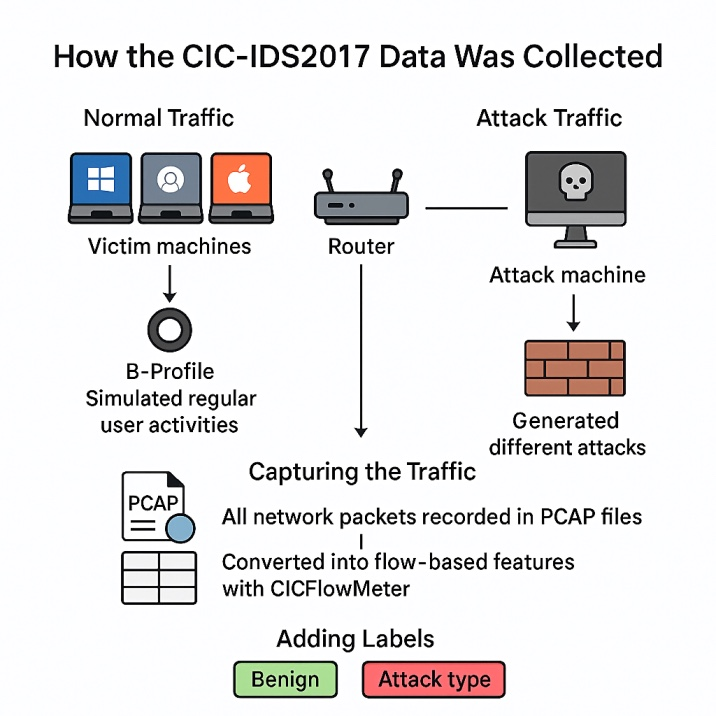

## 📝 Data Preparation


### ⬇️ Load and View Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
sns.set(style='darkgrid')

In [ ]:
import gdown, zipfile, os

# Google Drive dataset file ID & output name
file_id = "14DZKSHNcVHDsb0q4frPEQren7iNKCiE3"
output = "dataset.zip"

# Download ZIP
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=True)

# Unzip contents
extract_dir = "dataset"
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Get only valid CSVs
csv_files = [f for f in os.listdir("dataset/dataset") if f.endswith(".csv")]
csv_files = sorted(csv_files)  # sort to keep order consistent

# Load into individual DataFrames
data1 = pd.read_csv(os.path.join("dataset/dataset", csv_files[0]), encoding="latin1", low_memory=False)
data2 = pd.read_csv(os.path.join("dataset/dataset", csv_files[1]), encoding="latin1", low_memory=False)
data3 = pd.read_csv(os.path.join("dataset/dataset", csv_files[2]), encoding="latin1", low_memory=False)
data4 = pd.read_csv(os.path.join("dataset/dataset", csv_files[3]), encoding="latin1", low_memory=False)
data5 = pd.read_csv(os.path.join("dataset/dataset", csv_files[4]), encoding="latin1", low_memory=False)
data6 = pd.read_csv(os.path.join("dataset/dataset", csv_files[5]), encoding="latin1", low_memory=False)
data7 = pd.read_csv(os.path.join("dataset/dataset", csv_files[6]), encoding="latin1", low_memory=False)


In [ ]:
data_list = [data1, data2, data3, data4, data5, data6, data7]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 225745 rows, 79 columns
Data2 -> 286467 rows, 79 columns
Data3 -> 529918 rows, 79 columns
Data4 -> 288602 rows, 79 columns
Data5 -> 170366 rows, 79 columns
Data6 -> 445909 rows, 79 columns
Data7 -> 692703 rows, 79 columns


In [ ]:
# Basic dimensions and quick overview of data
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2639710
Number of columns: 79
Total cells: 208537090


In [ ]:
# Quick peek at the top rows to verify successful load
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

### ⬇️ Data Cleaning: fixing column names  

We remove any unnecessary spaces at the start or end of column names. This ensures column names are clean and consistent, making it easier to reference them in our code without mistakes.  


In [ ]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

### ⬇️ Data Cleaning: duplicate values

Duplicate rows mean the same network flow is recorded more than once. We check and remove duplicates to avoid biasing the model with repeated data.

In [ ]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated(keep=False)]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Preview some duplicate rows
duplicate_rows

Number of duplicate rows: 378682


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
76,21,50,1,2,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
109,22,187,1,1,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
111,22,111,1,1,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
384,443,161,2,0,0,0,0,0,0.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
386,465,49,2,0,37,0,37,0,18.5,26.162951,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692661,53,179,2,2,46,46,23,23,23.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692685,53,161,2,2,82,114,41,41,41.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692686,53,212,2,2,84,162,42,42,42.0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692691,443,3,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Remove duplicates (keep the first occurrence)
data = data.drop_duplicates(keep="first").reset_index(drop=True)
print(f"Shape after removing duplicates: {data.shape}")

Shape after removing duplicates: (2350116, 79)


### ⬇️ Data Cleaning: infinite values  

Some features may produce infinite values due to division by zero. We replace these with proper values (e.g., NaN) so the model can handle them correctly.  


In [ ]:
# Checking for number of infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      1147
Flow Packets/s    1472
dtype: int64


In [ ]:
# Replacing any infinite values with NaN
print(f'Initial missing values: {data.isna().sum().sum()}')
data.replace([np.inf, -np.inf], np.nan, inplace = True)
print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 325
Missing values after processing infinite values: 2944


### ⬇️ Data Cleaning: missing values

Missing values occur when some feature information is not recorded. We detect and handle them either by dropping or filling so they don’t cause errors or distort the analysis.

#### Step 1: Detect missing values

In [ ]:
# Count missing values per column
missing_counts = data.isna().sum()
print("Total missing values:", missing_counts.sum())

# Show only columns with missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

Total missing values: 2944


,0
Flow Bytes/s,1472
Flow Packets/s,1472


#### Step 2: Visualize missing values

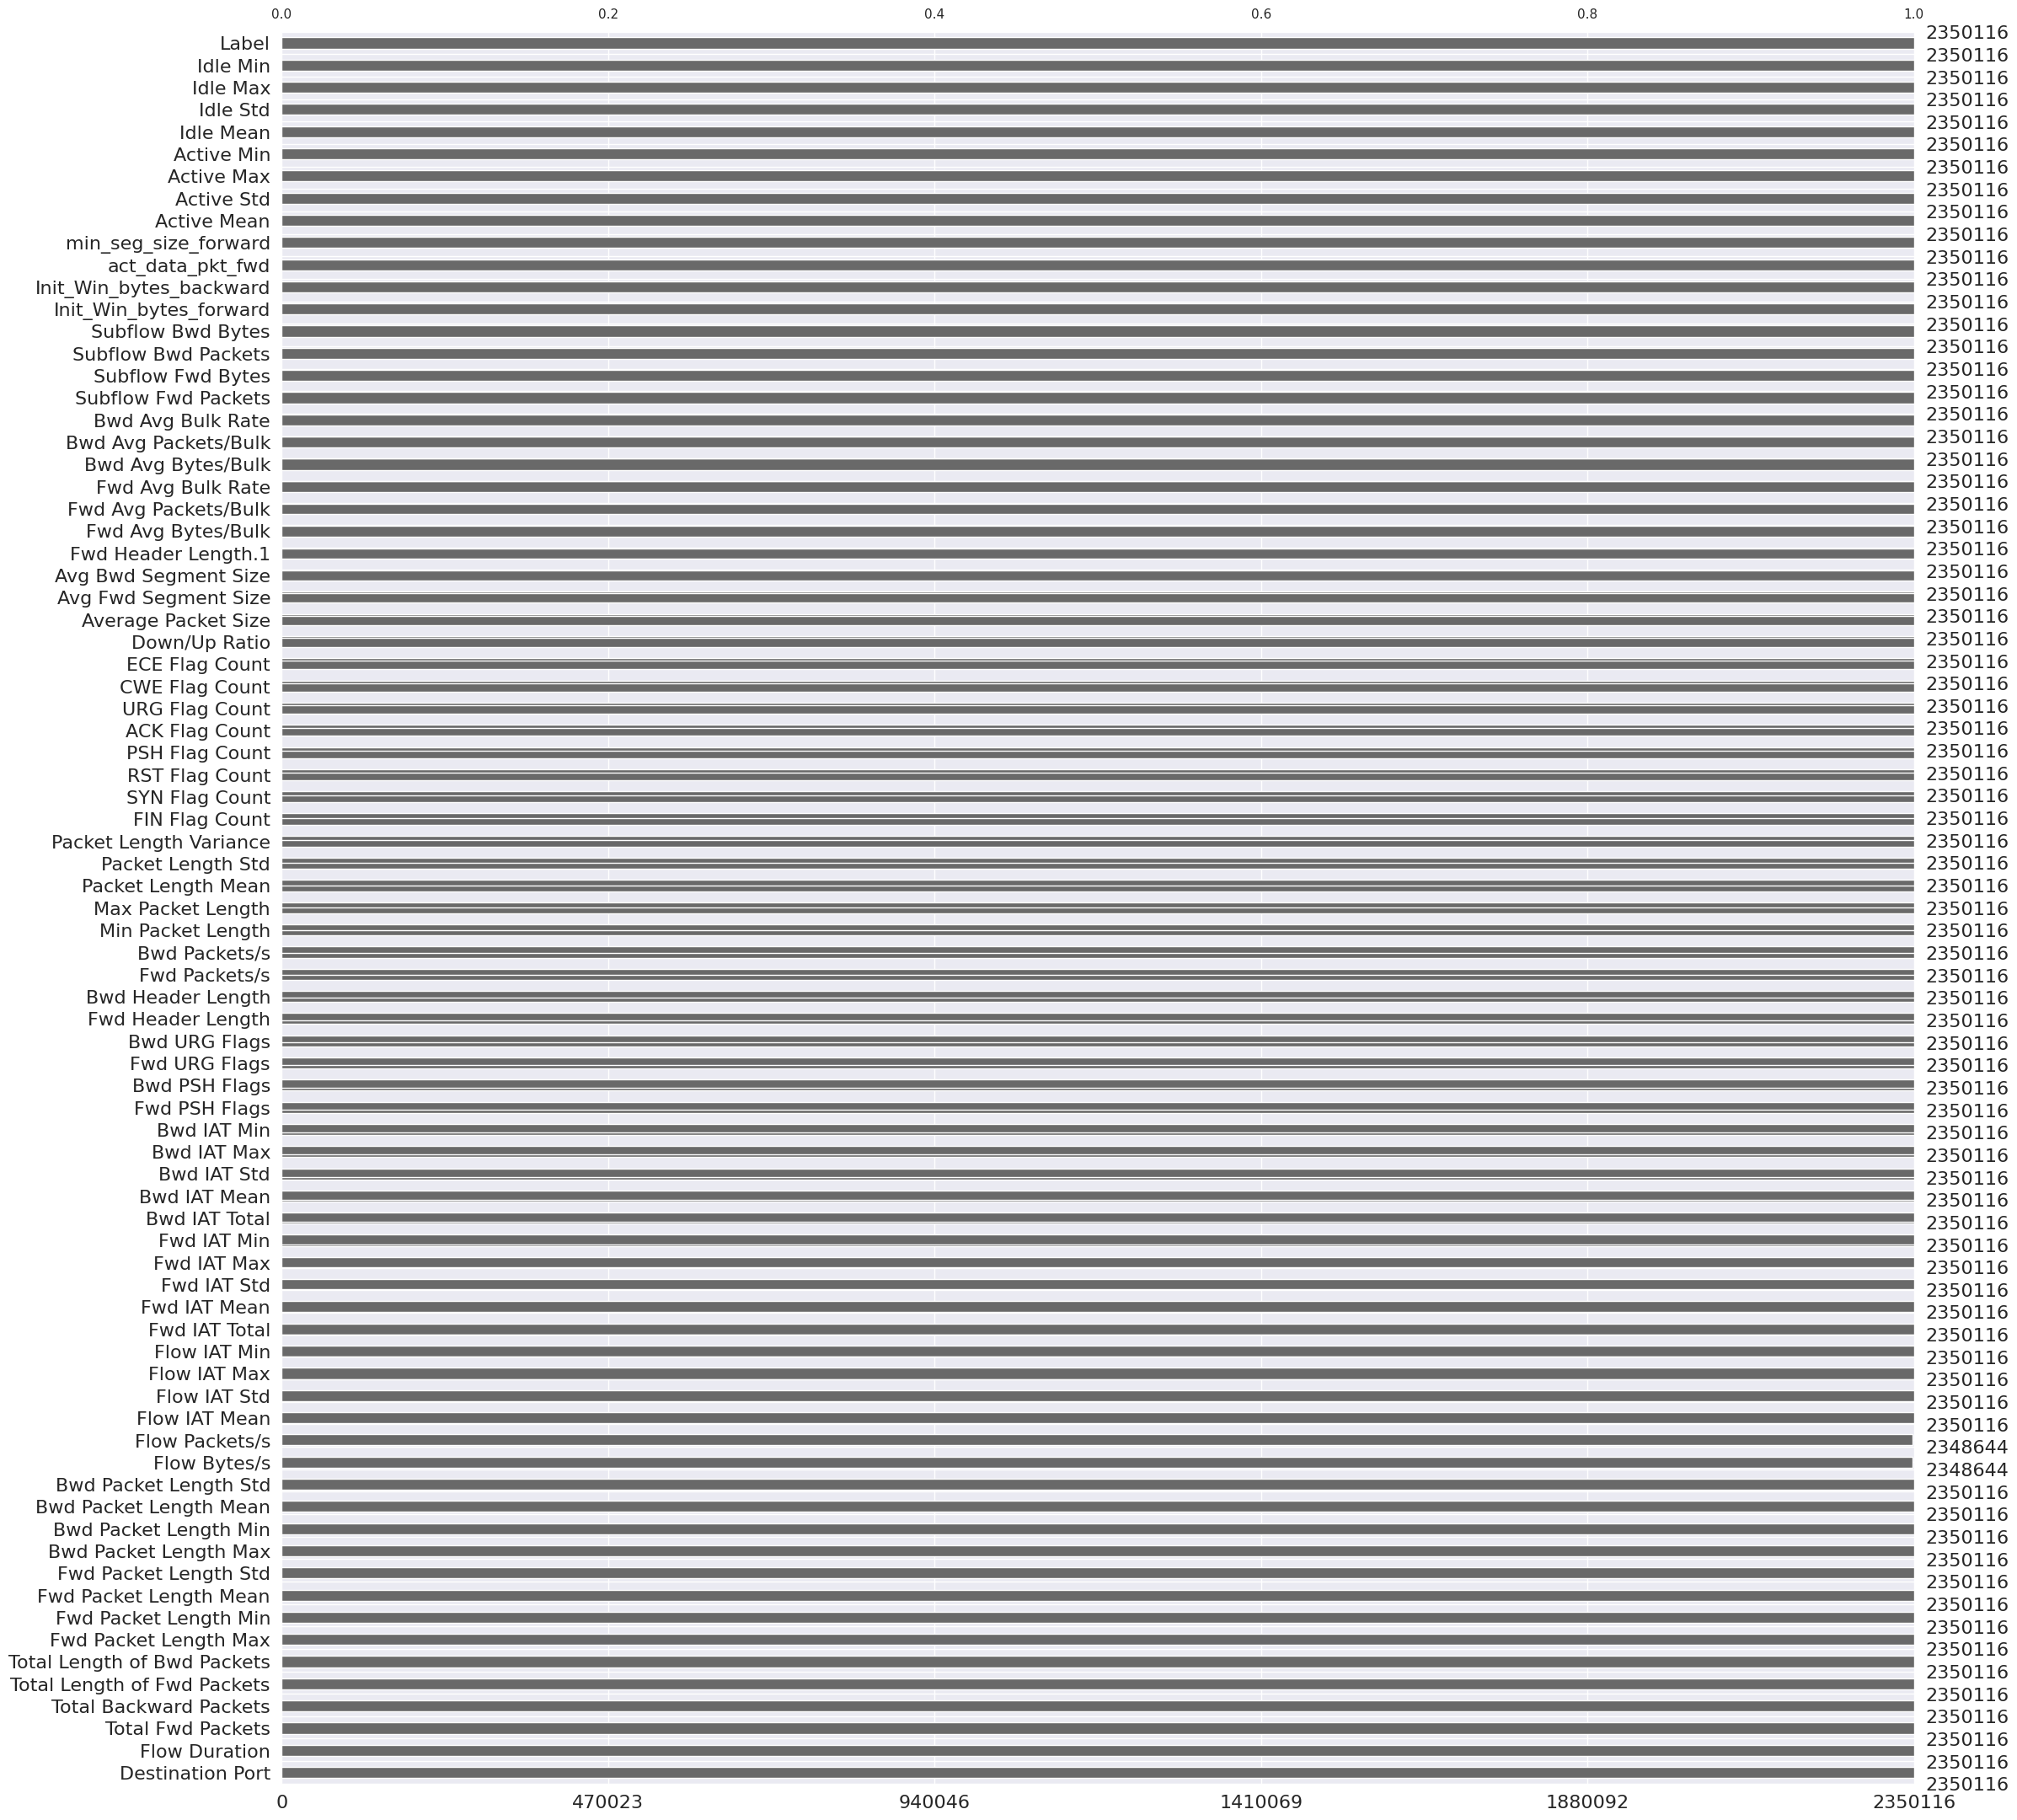

In [ ]:
plt.figure(figsize=(10, 4))
msno.bar(data)
plt.show()

#### Step 3: Handle missing values

A way to handle missing data is to simply remove any rows that contain NaN values. This ensures the dataset has no gaps, but it also reduces the amount of data available for analysis.  

**Note:** It’s useful when only a small fraction of rows are missing in data.  

In [ ]:
# Option 1: Drop rows with any missing values
rows_with_missing = data[data.isna().any(axis=1)]
print(f"Number of rows with missing values: {rows_with_missing.shape[0]}")

Number of rows with missing values: 1472


In [ ]:
# Verify missing values are gone
data_no_missing = data.dropna()
print("Shape after dropping rows with missing values:", data_no_missing.shape)
print("Total missing values left:", data_no_missing.isna().sum().sum())

Shape after dropping rows with missing values: (2348644, 79)
Total missing values left: 0


Instead of dropping rows with missing values, we can fill them in using simple rules.

- **Numeric columns:**  
  Replace missing numbers with the **mean** (average) value of that column.  
  Example: If `Flow Duration` is missing, we fill it with the average flow duration.

- **Categorical columns:**  
  Replace missing text/labels with the **most frequent value** (mode).  
  Example: If `Protocol` is missing, we fill it with the most common protocol type.

This way, we keep all rows in the dataset and avoid losing data, while still making sure there are no empty values that could break the model.

In [ ]:
# Option 2: Fill numeric columns with mean or mode
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  3642.2680714999997
Median of Flow Packets/s:  68.07285741499999


In [ ]:
# Filling missing values with median
data['Flow Bytes/s'] = data['Flow Bytes/s'].fillna(med_flow_bytes)
data['Flow Packets/s'] = data['Flow Packets/s'].fillna(med_flow_packets)

print('Number of \'Flow Bytes/s\' missing values:', data['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', data['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


### ⬇️ Data Preparation: feature selection/exctraction

Not all features are equally useful.  
- **Feature selection** → choosing the most relevant features (e.g., removing duplicates or low-importance ones).  
- **Feature extraction** → creating new, more informative features from existing ones (e.g., deriving *Hour* and *DayOfWeek* from *Timestamp*).  

In [ ]:
# Dropping columns that has only one unique value
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

### ⬇️ Data Preparation: data labeling

In the dataset, some attack labels are very detailed or written in slightly different ways (e.g., *"DoS Hulk"*, *"DoS GoldenEye"*, *"Web Attack XSS"*, etc.).  

**Label normalization** means:
- Cleaning inconsistent names (fixing typos/encoding issues).  
- Grouping similar labels into broader categories (e.g., all *DoS* attacks → DoS).  
- Creating a consistent set of labels so the model can learn more effectively.  

This makes the target variable easier to analyze and helps avoid confusion during training.


In [ ]:
# Types of attacks & normal instances
data['Label'].value_counts()

,count
Label,
BENIGN,1926191
DoS Hulk,172849
DDoS,128016
PortScan,90819
DoS GoldenEye,10286
FTP-Patator,5933
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219


In [ ]:
# Define the mapping dictionary
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack ï¿½ Brute Force': 'Web Attack',
    'Web Attack ï¿½ XSS': 'Web Attack',
    'Web Attack ï¿½ Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Create a new column with the broader attack category
data['Attack Type'] = data['Label'].map(attack_map)

print("Unique attack types:", data['Attack Type'].unique())

Unique attack types: ['BENIGN' 'DDoS' 'Port Scan' 'Infiltration' 'Web Attack' 'Brute Force'
 'DoS' 'Heartbleed']


In [ ]:
data.drop('Label', axis = 1, inplace = True)

In [ ]:
# Show corresponding attack type for each encoded value

le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Brute Force
2: DDoS
3: DoS
4: Heartbleed
5: Infiltration
6: Port Scan
7: Web Attack


### ⬇️ Data Preparation: class imbalance

The dataset is imbalanced, meaning that most traffic records are *Benign*, while attack samples are much fewer. If we trained on this directly, the model would likely predict *Benign* most of the time.  

To fix this, we:  
- Take an **equal number** of Benign and Attack flows.  
- **Relabel** them into binary classes:  
  - `0` → Benign  
  - `1` → Attack  

This way, the dataset is balanced and the model can learn both classes more effectively.  


In [ ]:
# Creating a balanced dataset for Binary Classification
normal_traffic = data.loc[data['Attack Type'] == 'BENIGN']
intrusions = data.loc[data['Attack Type'] != 'BENIGN']

normal_traffic = normal_traffic.sample(n = len(intrusions), replace = False)

new_data = pd.concat([intrusions, normal_traffic])
new_data['Attack Type'] = np.where((new_data['Attack Type'] == 'BENIGN'), 0, 1)
bc_data = new_data.sample(n = 15000)

print(bc_data['Attack Type'].value_counts())

Attack Type
1    7511
0    7489
Name: count, dtype: int64


### ⬇️ Data Preparation: data splitting

We split the dataset into **training** and **testing** parts:  
- **Training set** → used to teach the model patterns.  
- **Testing set** → used to check how well the model performs on unseen data.  

This prevents overfitting and gives a fair evaluation of the model.  

In [ ]:
# Splitting the data into features X and target y
from sklearn.model_selection import train_test_split

X_bc = bc_data.drop('Attack Type', axis = 1)
y_bc = bc_data['Attack Type']

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size = 0.25, random_state = 0)

In [ ]:
print("Shape of training features:", X_train_bc.shape)
print("Shape of training labels:", y_train_bc.shape)
print("Shape of test features:", X_test_bc.shape)
print("Shape of test labels:", y_test_bc.shape)

Shape of training features: (11250, 71)
Shape of training labels: (11250,)
Shape of test features: (3750, 71)
Shape of test labels: (3750,)


## 📝 Data Visualization

### ⬇️ Attack Frequency

This visualization shows the frequency of each cyber attack type in the dataset excluding normal traffic. The bars are ordered from the most common attack to the least common and each bar is labeled with its count. This helps us quickly see which attacks are most frequent in the data.

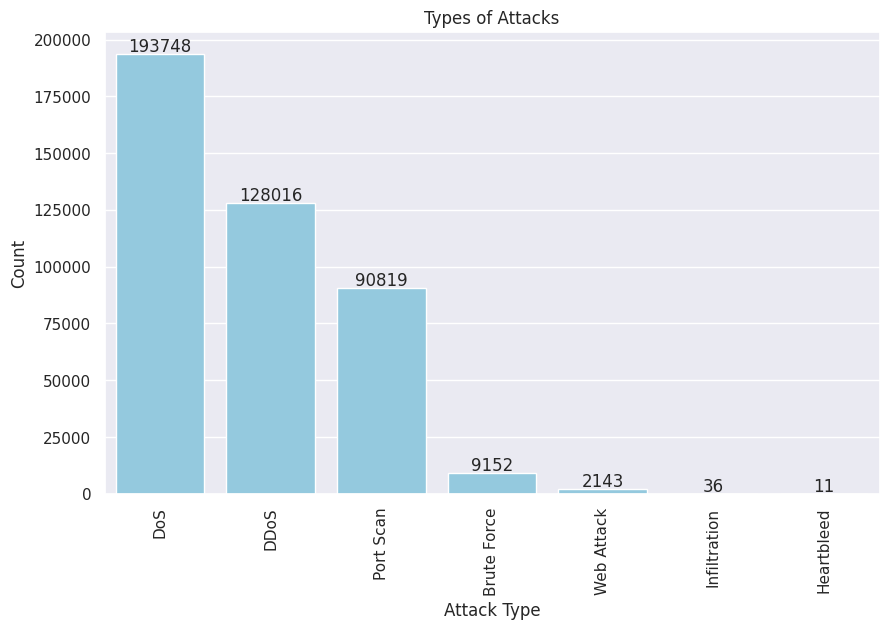

In [ ]:
# Different attack types in the main dataset excluding normal traffic
attacks = data.loc[data['Attack Type'] != 'BENIGN']
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Attack Type", data=attacks, order=attacks["Attack Type"].value_counts().index, color="skyblue")
plt.title('Types of Attacks')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation = 90)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height() + 1000), ha = 'center')

plt.show()

### ⬇️ Flow Duration of Attacks

A box plot helps us see how the values of a numeric feature are spread across different attack types.  

Here we compare **Flow Duration** for each attack type:  
- The **box** shows the middle 50% of the values.  
- The **line inside the box** is the median.  
- The **dots (outliers)** show unusual flows that are very different from the majority.  

This plot is useful because some attacks, like DoS/DDoS, create flows that are much shorter or longer than normal traffic, making them easier to detect.  


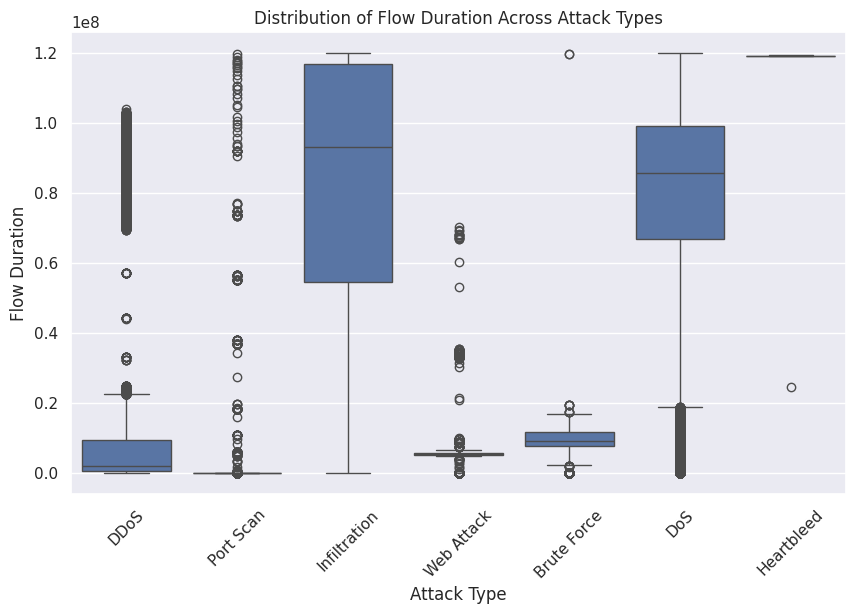

In [ ]:
# Flow duration of different attack types
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[data['Attack Type'] != 'BENIGN'],
            x='Attack Type', y='Flow Duration')
plt.title('Distribution of Flow Duration Across Attack Types')
plt.xticks(rotation=45)
plt.ylabel('Flow Duration')
plt.show()
